<a href="https://colab.research.google.com/github/Zewtta/PEL219_2025_RedesNeuraisArtificiais/blob/main/PEL219_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarefa 8
##Aluno: Matheus Vieira Martins
##Mestrado Eng. Mecânica

#### Anotações de aulas:
Exercício
Então, usem LSTM e GRU para comparar com o trabalho de CNN1D já entregue.
- Escolham uma base de dados de série temporal e realize uma classificação/predição.
- Pode ser qualquer série, mas na UCI ML Archive tem muitos.

Compare os resultados e o desempenho.

#Resultados obtidos

A rede CNN retornou um R² = 0.95 enquando o treinamento com RNN patience 2 retornou R² = 0.97

#Loading dos dados
ElectricityLoadDiagrams20112014:
- https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014

Dimensões: (140256, 370)
Head:
                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                     MT_364  MT_365  

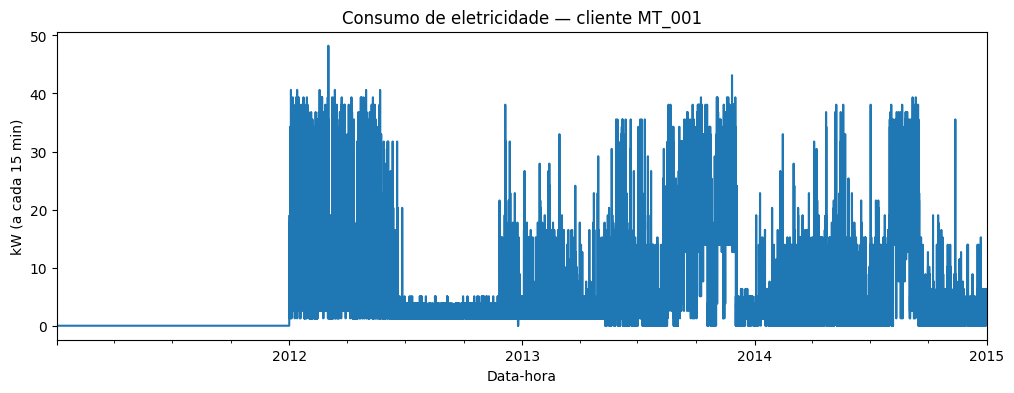

In [ ]:
import os
import requests, zipfile, io
import pandas as pd

# 1) Download do dataset (zip + txt)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/uci_electricity/")  # vai criar a pasta

# 2) Carregar em pandas
filepath = os.path.join("data/uci_electricity", "LD2011_2014.txt")
df = pd.read_csv(
    filepath,
    sep=";",
    decimal=",",
    index_col=0
)
df.index = pd.to_datetime(df.index)  # converte o índice para datetime

df.head()

# 3) Inspeção inicial
print("Dimensões:", df.shape)
print("Head:")
print(df.head())
print("Tail:")
print(df.tail())

# 4) Exemplo: plotar uma das séries (por cliente)
import matplotlib.pyplot as plt
cliente = df.columns[0]  # por exemplo o primeiro cliente
df[cliente].plot(figsize=(12,4))
plt.title(f"Consumo de eletricidade — cliente {cliente}")
plt.xlabel("Data-hora")
plt.ylabel("kW (a cada 15 min)")
plt.show()


# RNN base temporal - Patience 2


Total de pontos: 70080
X shape: (69984, 96)
y shape: (69984,)
trainX: (55987, 96, 1)
testX : (13997, 96, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,497 (91.79 KB)

 Trainable params: 23,497 (91.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 71s 39ms/step - loss: 0.0071 - val_loss: 7.5867e-04
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 68s 39ms/step - loss: 7.6013e-04 - val_loss: 6.7330e-04
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - loss: 6.9408e-04 - val_loss: 6.5760e-04
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - loss: 6.6463e-04 - val_loss: 5.6763e-04
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 87s 41ms/step - loss: 6.5519e-04 - val_loss: 6.1570e-04
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - loss: 6.3143e-04 - val_loss: 6.0622e-04
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step

===== RESULTADOS =====
MAE : 27.19514717347629
MSE : 1415.7781094265192
RMSE: 37.626826991210926
R²  : 0.9743739362549952


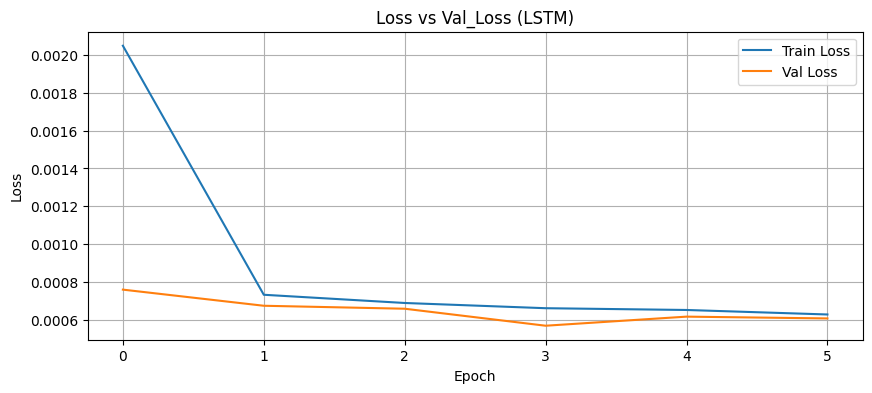

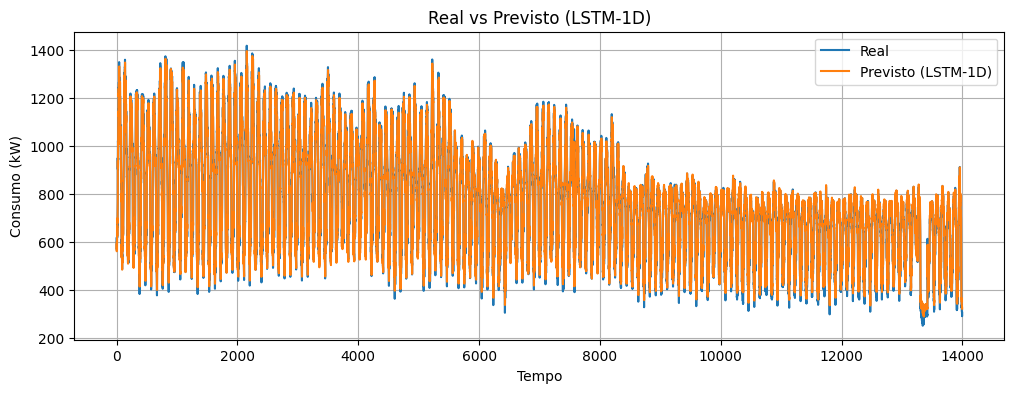

In [ ]:
# =========================================
# IMPORTS
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM   # <-- troquei Conv1D, MaxPooling1D, Flatten por LSTM
from keras.callbacks import EarlyStopping


# =========================================
# 1) SELECIONAR CLIENTE E FILTRAR PERÍODO
# =========================================
cliente = "MT_200"    # troque depois por outro cliente bom
serie = df[cliente].astype(float).loc["2013-01-01":"2014-12-31"].dropna()

print("Total de pontos:", len(serie))

values = serie.values.reshape(-1,1)

# =========================================
# 2) NORMALIZAÇÃO
# =========================================
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values).flatten()

# =========================================
# 3) FUNÇÃO PARA CRIAR JANELAS (WINDOWS)
# =========================================
def make_windows(x, window_size=96, horizon=1):
    X, y = [], []
    for i in range(len(x) - window_size - horizon + 1):
        seq_x = x[i : i + window_size]
        seq_y = x[i + window_size + horizon - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

WINDOW_SIZE = 96   # 24h (15 min * 96)
HORIZON     = 1    # prever próximo ponto

X, y = make_windows(values_scaled, WINDOW_SIZE, HORIZON)

print("X shape:", X.shape)  # (amostras, janela)
print("y shape:", y.shape)  # (amostras,)

# =========================================
# 4) SPLIT TREINO/TESTE 80/20
# =========================================
split = int(len(X) * 0.8)
trainX, trainy = X[:split], y[:split]
testX,  testy  = X[split:], y[split:]

# Conv1D requer 3D → reshape: (amostras, janela, features=1)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX  = testX.reshape((testX.shape[0],  testX.shape[1],  1))

print("trainX:", trainX.shape)
print("testX :", testX.shape)

# ... (tudo igual até o reshape em trainX/testX)

# =========================================
# 5) DEFINIR A REDE LSTM
# =========================================
model = Sequential()
# LSTM "1D": sequência de 96 passos, 1 feature por passo
model.add(
    LSTM(
        units=64,
        activation="tanh",            # padrão de LSTM
        recurrent_activation="sigmoid",
        input_shape=(WINDOW_SIZE, 1)
    )
)
# camada totalmente conectada depois da LSTM
model.add(Dense(100, activation='relu'))
model.add(Dense(1))  # saída contínua para regressão

model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

# =========================================
# 6) EARLY STOPPING
# =========================================
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# =========================================
# 7) TREINAMENTO
# =========================================
history = model.fit(
    trainX, trainy,
    validation_data=(testX, testy),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# =========================================
# 8) PREDIÇÃO + DESNORMALIZAÇÃO
# =========================================
pred_scaled = model.predict(testX).flatten()

y_true = scaler.inverse_transform(testy.reshape(-1,1)).flatten()
y_pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

# =========================================
# 9) MÉTRICAS
# =========================================
mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

print("\n===== RESULTADOS =====")
print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R²  :", r2)

# =========================================
# 10) PLOTS
# =========================================
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss vs Val_Loss (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_true, label='Real')
plt.plot(y_pred, label='Previsto (LSTM-1D)')
plt.title("Real vs Previsto (LSTM-1D)")
plt.xlabel("Tempo")
plt.ylabel("Consumo (kW)")
plt.legend()
plt.grid(True)
plt.show()


# RNN base temporal - Patience 4


Total de pontos: 70080
X shape: (69984, 96)
y shape: (69984,)
trainX: (55987, 96, 1)
testX : (13997, 96, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,497 (91.79 KB)

 Trainable params: 23,497 (91.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - loss: 0.0063 - val_loss: 8.0932e-04
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 84s 41ms/step - loss: 7.5818e-04 - val_loss: 6.3690e-04
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - loss: 6.9023e-04 - val_loss: 6.0249e-04
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - loss: 6.7090e-04 - val_loss: 6.4056e-04
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - loss: 6.4997e-04 - val_loss: 6.0046e-04
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - loss: 6.3587e-04 - val_loss: 6.6005e-04
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 68s 39ms/step - loss: 6.0004e-04 - val_loss: 5.7636e-04
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - loss: 5.8504e-04 - val_loss: 6.0673e-04
Epoch 9/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 68s 39ms/step - loss: 5.6708e-04 - val_loss: 5.4944e-04
Epoch 10/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 68s 39ms/step - loss: 5.6715e-04 - val_loss: 5.6263e-04
Epoch 11

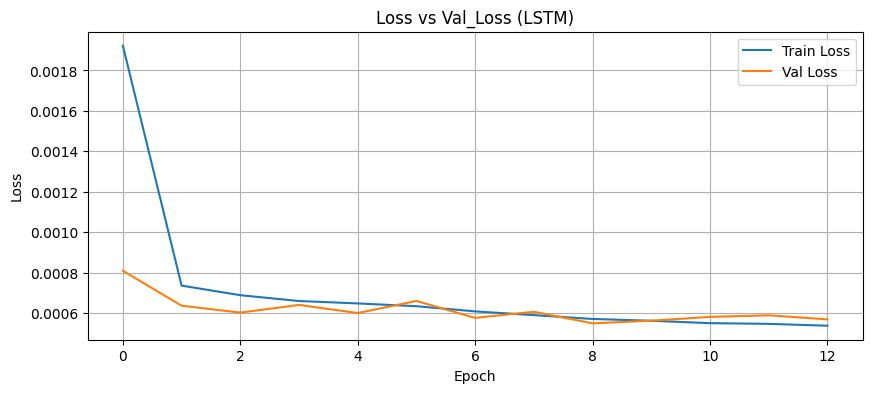

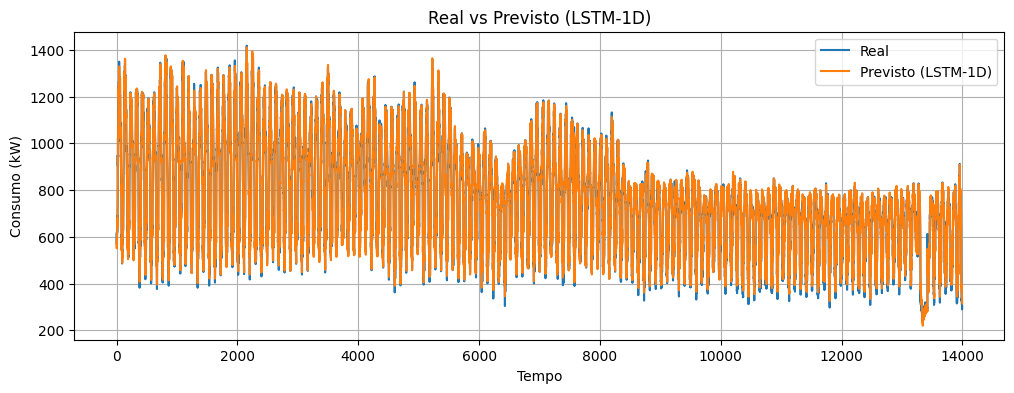

In [ ]:
# =========================================
# IMPORTS
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM   # <-- troquei Conv1D, MaxPooling1D, Flatten por LSTM
from keras.callbacks import EarlyStopping


# =========================================
# 1) SELECIONAR CLIENTE E FILTRAR PERÍODO
# =========================================
cliente = "MT_200"    # troque depois por outro cliente bom
serie = df[cliente].astype(float).loc["2013-01-01":"2014-12-31"].dropna()

print("Total de pontos:", len(serie))

values = serie.values.reshape(-1,1)

# =========================================
# 2) NORMALIZAÇÃO
# =========================================
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values).flatten()

# =========================================
# 3) FUNÇÃO PARA CRIAR JANELAS (WINDOWS)
# =========================================
def make_windows(x, window_size=96, horizon=1):
    X, y = [], []
    for i in range(len(x) - window_size - horizon + 1):
        seq_x = x[i : i + window_size]
        seq_y = x[i + window_size + horizon - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

WINDOW_SIZE = 96   # 24h (15 min * 96)
HORIZON     = 1    # prever próximo ponto

X, y = make_windows(values_scaled, WINDOW_SIZE, HORIZON)

print("X shape:", X.shape)  # (amostras, janela)
print("y shape:", y.shape)  # (amostras,)

# =========================================
# 4) SPLIT TREINO/TESTE 80/20
# =========================================
split = int(len(X) * 0.8)
trainX, trainy = X[:split], y[:split]
testX,  testy  = X[split:], y[split:]

# Conv1D requer 3D → reshape: (amostras, janela, features=1)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX  = testX.reshape((testX.shape[0],  testX.shape[1],  1))

print("trainX:", trainX.shape)
print("testX :", testX.shape)

# ... (tudo igual até o reshape em trainX/testX)

# =========================================
# 5) DEFINIR A REDE LSTM
# =========================================
model = Sequential()
# LSTM "1D": sequência de 96 passos, 1 feature por passo
model.add(
    LSTM(
        units=64,
        activation="tanh",            # padrão de LSTM
        recurrent_activation="sigmoid",
        input_shape=(WINDOW_SIZE, 1)
    )
)
# camada totalmente conectada depois da LSTM
model.add(Dense(100, activation='relu'))
model.add(Dense(1))  # saída contínua para regressão

model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

# =========================================
# 6) EARLY STOPPING
# =========================================
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# =========================================
# 7) TREINAMENTO
# =========================================
history = model.fit(
    trainX, trainy,
    validation_data=(testX, testy),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# =========================================
# 8) PREDIÇÃO + DESNORMALIZAÇÃO
# =========================================
pred_scaled = model.predict(testX).flatten()

y_true = scaler.inverse_transform(testy.reshape(-1,1)).flatten()
y_pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

# =========================================
# 9) MÉTRICAS
# =========================================
mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

print("\n===== RESULTADOS =====")
print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R²  :", r2)

# =========================================
# 10) PLOTS
# =========================================
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss vs Val_Loss (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_true, label='Real')
plt.plot(y_pred, label='Previsto (LSTM-1D)')
plt.title("Real vs Previsto (LSTM-1D)")
plt.xlabel("Tempo")
plt.ylabel("Consumo (kW)")
plt.legend()
plt.grid(True)
plt.show()
